<a href="https://colab.research.google.com/github/NeevSabhani/Data-Science/blob/main/Unit5/NeevSabhani_Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [2]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [4]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [3]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

<Axes: xlabel='FT%', ylabel='FG%'>

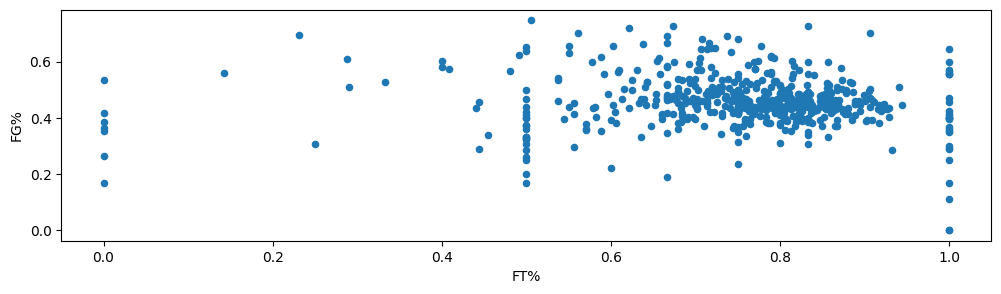

In [4]:
basketball.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

I notice that a very large amount of players are in the 60 to 90 percent FT% as well as the 40 to 60 percent FG%. These are most likely your normal average nba players (role players). The higher ends, so near the 85% and the 50-55%, those are most likely your star players as they usually have higher fg% and higher Ft%.

However, outisde of that big blob and the other points scattered around, there are these lines on the 0%, 50%, and 100% FT%. These are most likely caused by a small sample size with players shooting only 1-2 free throws and either missing both, making one, or making both which leads to the 0, 50, and 100% FT%.

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

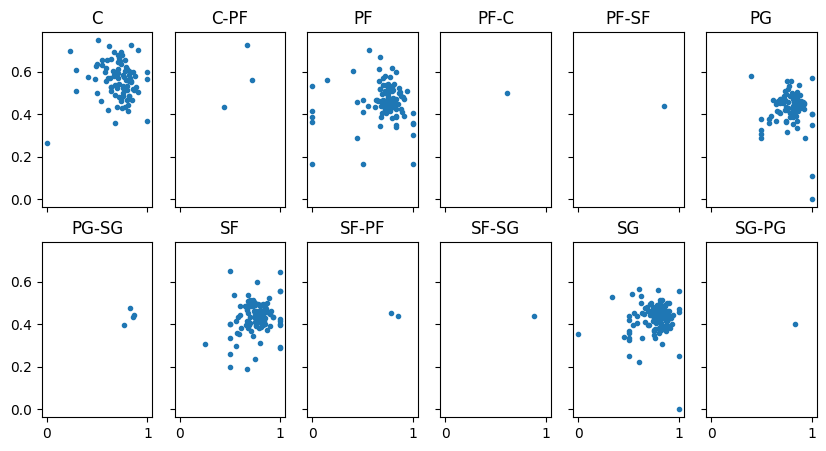

In [15]:
pos_idx = basketball.Pos.cat.codes.values

pos_codes = basketball.Pos.cat.categories

bb_coords = {"pos":pos_codes}

_, ax = plt.subplots(2, 6, figsize=(10,5), sharex=True, sharey=True)
ax = np.ravel(ax)

for i, p in enumerate(pos_codes):
  ax[i].scatter(
      x = basketball.query('Pos == @p')['FT%'],
      y = basketball.query('Pos == @p')['FG%'],
      marker = "." )
  ax[i].set_title(f"{p}")

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

A linear regression model fails to work effectively on the full basketball dataset due to the presence of extreme values and structural inconsistencies in the data. When analyzing the scatter plots, we observe clear issues:

**Extreme FT% Values (0% and 100%)**: These values represent players who attempted very few free throws. For example, a player who took only one or two free throws in the season will have either a 0%, 50%, or 100% FT%. These extreme values are outliers that disproportionately influence the regression line. Linear regression is highly sensitive to outliers, so these data points cause instability in parameter estimation.

**Variability by Position**: The relationship between FT% and FG% varies significantly across positions. For instance, Centers (C) tend to have lower FT% due to limited shooting ability but higher FG% from close-range attempts. Guards (G), in contrast, often have better FT% but slightly lower FG% due to their shot selection. This variability means a single regression line cannot accurately model all positions.

**Clustering and Nonlinearity**: A large cluster of data exists within the 60-90% FT% and 40-60% FG% range, while the remaining data points are widely scattered. The model struggles to fit both the dense cluster and the outliers, leading to poor predictions.

**Leverage Points**: Additionally, the dataset contains leverage points—data points with extreme FT% or FG% values that exert an outsized influence on the regression line. These leverage points disproportionately pull the line towards them, distorting the overall trend and reducing the model's predictive accuracy. For instance, a player with a very high FG% due to close-range shooting (e.g., a Center primarily taking layups and dunks) or a very low FG% due to limited minutes may represent leverage points that skew the model’s performance. These points make it even harder for a single regression line to capture the general relationship between FT% and FG%.



## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [6]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [7]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

<Axes: xlabel='height', ylabel='weight'>

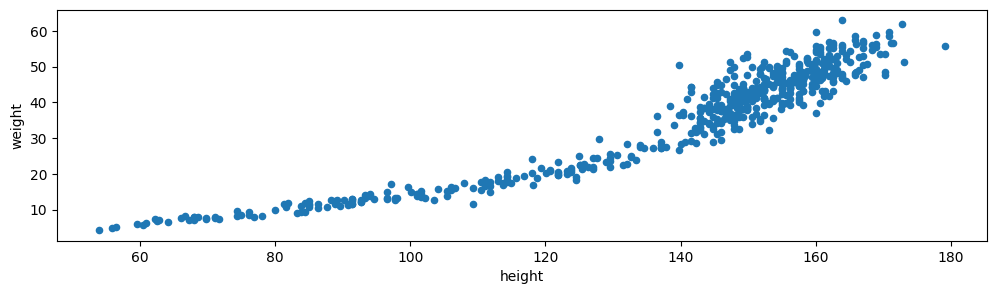

In [8]:
howell.plot(x="height", y="weight", figsize=(12, 3), kind="scatter")

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

Output()

Output()

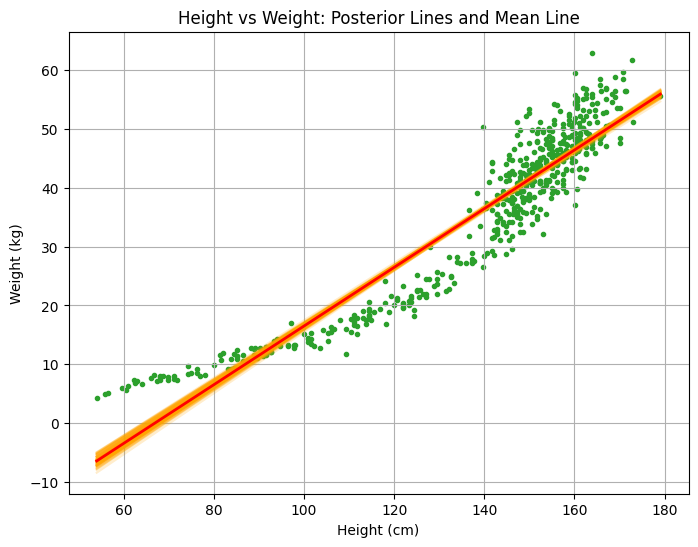

In [45]:
# Linear regression model with PyMC
with pm.Model() as model_howell:

    #priors for the linear part of our model
    α = pm.Normal("alpha",sigma=10)
    β = pm.Normal("beta",sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * howell.height)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfNormal("σ", sigma =10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    #inference data object
    idata_howell = pm.sample()

# Grab 100 posterior samples from the linear regression model
posterior = az.extract(idata_howell, num_samples=100)

# Generate x values for graphing
x_plot = xr.DataArray(
    np.linspace(howell.height.min(), howell.height.max(), 50),
    dims="plot_id"
)

# Compute the mean regression line
mean_line = posterior["alpha"].mean() + posterior["beta"].mean() * x_plot

# Generate 100 regression lines from posterior samples
lines = posterior["alpha"] + posterior["beta"] * x_plot

# Set up the plot
_, ax = plt.subplots(figsize=(8, 6))

# Plot the 100 regression lines from the posterior
ax.plot(x_plot, lines.T, c="orange", alpha=0.2)

# Plot the mean regression line
ax.plot(x_plot, mean_line, c="red", linewidth=2)

# Scatter plot of raw data
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)

# Label axes and title
ax.set_xlabel("Height (cm)")
ax.set_ylabel("Weight (kg)")
ax.set_title("Height vs Weight: Posterior Lines and Mean Line")
plt.grid(True)
plt.show()


array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

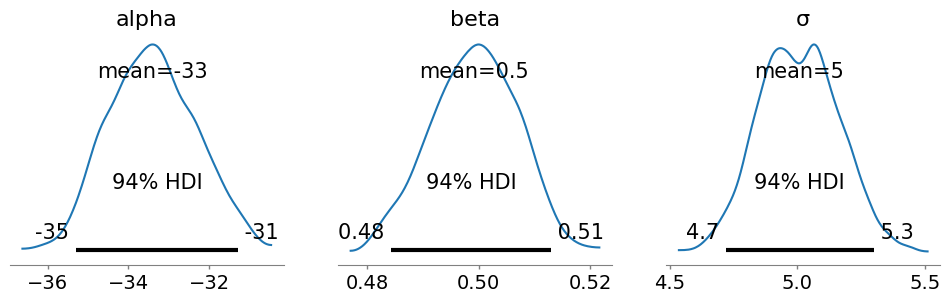

In [50]:
az.plot_posterior(idata_howell, var_names=["~μ"], figsize=(12, 3))

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

In [46]:

# posterior predictive check
pm.sample_posterior_predictive(idata_howell, model=model_howell,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'weight')

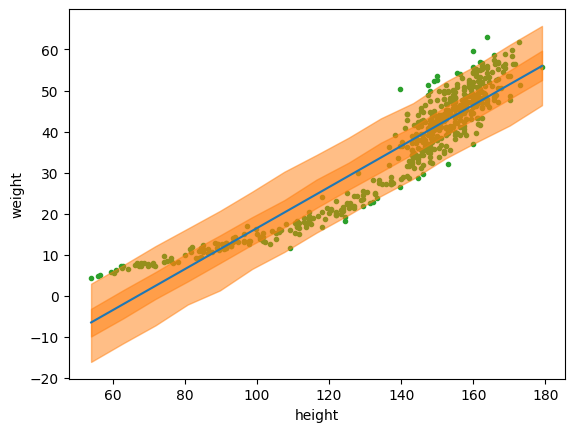

In [48]:
mean_line = idata_howell.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
temperatures = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_howell.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("height")
ax.set_ylabel("weight")


<Axes: xlabel='y_pred'>

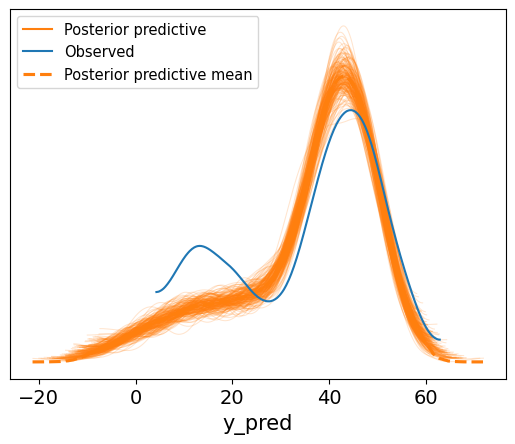

In [49]:
# Perform posterior predictive check using az.plot_ppc
az.plot_ppc(idata_howell, num_pp_samples=200, colors=["C1", "C0", "C1"])



**The Fit**


The model is okay at best. The peak of our model overshoots the actual code and the second hump isn't accounted for in our model. However, the model does follow the ends pretty well which is the good. This model has lots of room for improvement.

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [39]:
# Linear regression model with PyMC
with pm.Model() as model_lb:

    #priors for the linear part of our model
    α = pm.Normal("alpha",sigma=10)
    β = pm.Normal("beta",sigma=10)
    sigma = pm.Normal("sigma", sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", pm.math.exp(α + β * howell.height))

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfNormal("σ", pm.math.exp(sigma))

    #likelihood
    y_pred = pm.Normal("weight_obs", mu=μ, sigma=σ, observed=howell.weight)

    #inference data object
    trace_howell = pm.sample()



Output()

Output()

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'sigma'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

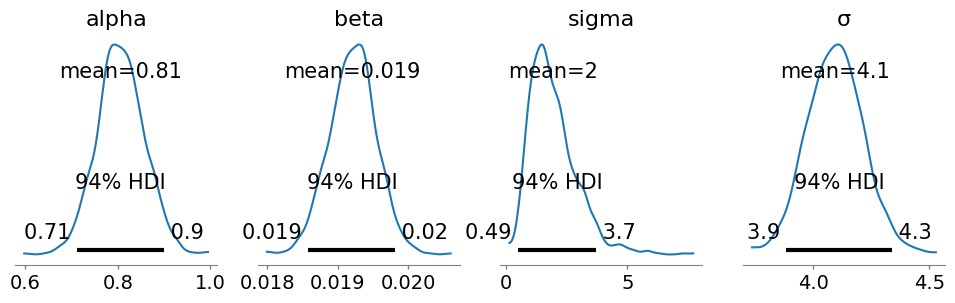

In [51]:
az.plot_posterior(trace_howell, var_names=["~μ"], figsize=(12, 3))

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

In [40]:
pm.sample_posterior_predictive(trace_howell, model=model_lb,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='weight_obs'>

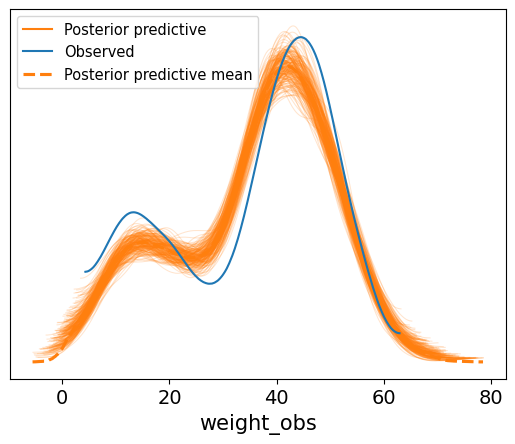

In [41]:
# Perform posterior predictive check using az.plot_ppc
az.plot_ppc(trace_howell, num_pp_samples=200, colors=["C1", "C0", "C1"])

**The Fit**

The fit of this model is way better. The peak of the rightmost hump is much closer to the actual data and this time the second hump is actually accounted for; however, the peak of the second hump slightly undershoots the actual height of the peak. The left tail is alright and the right side tail matches very well. While the model may not be perfect, there has been huge improvement from the previous model.

Text(0, 0.5, 'weight')

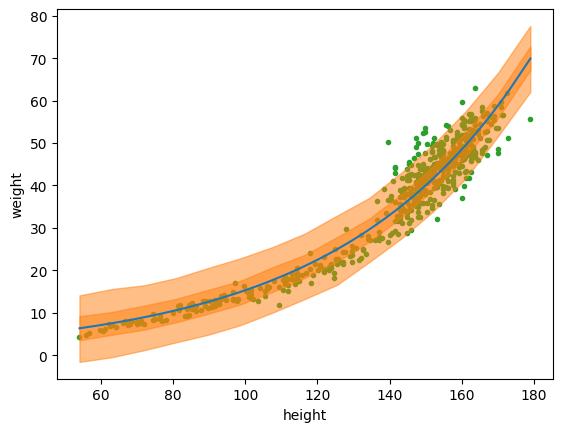

In [42]:
mean_line = trace_howell.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
temperatures = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = trace_howell.posterior_predictive["weight_obs"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("height")
ax.set_ylabel("weight")
